In [1]:
# Import the neccessary libraries
import pandas as pd
import re
import numpy as np
import warnings
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import metrics

# Change a few settings to be more to my liking
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', None)
pd.options.display.float_format = '{:.4f}'.format

In [2]:
# Download the current edition of my excel file from OneDrive
url = "https://onedrive.live.com/download?resid=936C0322EB2B7176%21295913&authkey=!AAh5R2TWeWOekM0&em=2"
movie = pd.read_excel(url)

movie = pd.read_csv(open(path + 'Movie_Rankings.csv', encoding="utf8", errors='ignore'))

In [3]:
# Get a look at the dataset
movie.head()

,Film Title,My Rating,Genre,Director,Writer,Producer,Protagonist,Starring,Cinematographer,Editor,Composer,Production Company,Distributor,Release Date,Runtime,Real Budget,Real Box Office,Real Profit,Inflated Budget,Inflated Box Office,Inflated Profit,ROI,True ROI,Franchise,Sub-Franchise,Rating,Oscar Achievements,RT Critics Rating,RT Fan Rating,MC Critics Score,MC User Score,IMDB Rating,Letterboxd Rating,Was I Watching?,Watch Date,Movie Age,Movie Age At Watch,Rank,Statistics
0,The Shawshank Redemption,10.0000,"Drama, Prison",Frank Darabont,Frank Darabont,Niki Marvin,Tim Robbins,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Roger Deakins,Richard Francis-Bruce,Thomas Newman,Castle Rock Entertainment,Columbia Pictures,1994-09-23,142,25000000.0000,73300000.0000,48300000.0000,51357733.1759,150580873.6718,99223140.4959,2.9320,1.1728,Solo Film,NaN,R,"Best Picture Nominee, Best Actor Nominee, Best...",91.0000,98.0000,82.0000,9.0000,9.3000,4.5000,Yes,2023-12-15,10765 Days,10675 Days,100.0000,Watched a Movie on
1,Memento,9.9000,"Drama, Mystery, Thriller, Neo-noir, Psychological",Christopher Nolan,Christopher Nolan,"Suzanne Todd, Jennifer Todd",Guy Pearce,"Guy Pearce, Carrie-Anne Moss, Joe Pantoliano",Wally Pfister,Dody Dorn,David Julyan,"Summit Entertainment, Team Todd",Newmarket,2001-03-16,113,5000000.0000,40100000.0000,35100000.0000,8598456.3253,68959619.7289,60361163.4036,8.0200,3.2080,Solo Film,NaN,R,Best Original Screenplay Nominee,94.0000,94.0000,83.0000,8.9000,8.4000,4.2000,Yes,2024-02-14,8399 Days,8370 Days,99.0000,54.5% of days
2,Hereditary,9.8000,"Horror, Psychological, Drama, Supernatural",Ari Aster,Ari Aster,"Kevin Frakes, Lars Knudsen, Buddy Patrick",Toni Collette,"Toni Collette, Alex Wolff, Milly Shapiro, Ann ...",Pawel Pogorzelski,"Jennifer Lame, Lucian Johnston",Colin Stetson,"A24, PalmStar Media, Finch Entertainment, Wind...",A24,2018-06-08,127,10000000.0000,82800000.0000,72800000.0000,12126312.7713,100405869.7460,88279556.9748,8.2800,3.3120,Solo Film,NaN,R,NaN,90.0000,70.0000,87.0000,6.7000,7.3000,4.0000,Yes,2023-10-19,2106 Days,1959 Days,98.0000,Average Movie Score
3,Get Out,9.7000,"Horror, Thriller, Psychological",Jordan Peele,Jordan Peele,"Sean McKittrick, Jason Blum, Edward H. Hamm Jr...",Daniel Kaluuya,"Daniel Kaluuya, Allison Williams, Bradley Whit...",Toby Oliver,Gregory Plotkin,Michael Abels,"Blumhouse Productions, QC Entertainment, Monke...",Universal Pictures,2017-02-24,104,4500000.0000,255400000.0000,250900000.0000,5590128.6277,317270855.8918,311680727.2641,56.7556,22.7022,Solo Film,NaN,R,"Best Picture Nominee, Best Director Nominee, B...",98.0000,86.0000,85.0000,7.5000,7.8000,4.2000,Yes,2024-01-01,2575 Days,2502 Days,96.0000,6.6230
4,Scream (1996),9.7000,"Horror, Slasher, Mystery, Comedy",Wes Craven,Kevin Williamson,"Cathy Konrad, Cary Woods",Neve Campbell,"David Arquette, Neve Campbell, Courteney Cox, ...",Mark Irwin,Patrick Lussier,Marco Beltrami,Woods Entertainment,Dimension Films,1996-12-20,111,14000000.0000,173000000.0000,159000000.0000,27178833.2802,335852725.5339,308673892.2537,12.3571,4.9429,Scream,NaN,R,NaN,81.0000,80.0000,65.0000,8.6000,7.4000,4.0000,Yes,2023-10-03,9946 Days,9783 Days,96.0000,Median Movie Score


In [4]:
# Check which columns are currently in the dataset
movie.columns.values.tolist()

['Film Title',
 'My Rating',
 'Genre',
 'Director',
 'Writer',
 'Producer',
 'Protagonist',
 'Starring',
 'Cinematographer',
 'Editor',
 'Composer',
 'Production Company',
 'Distributor',
 'Release Date',
 'Runtime',
 'Real Budget',
 'Real Box Office',
 'Real Profit',
 'Inflated Budget',
 'Inflated Box Office',
 'Inflated Profit',
 'ROI',
 'True ROI',
 'Franchise',
 'Sub-Franchise',
 'Rating',
 'Oscar Achievements',
 'RT Critics Rating',
 'RT Fan Rating',
 'MC Critics Score',
 'MC User Score',
 'IMDB Rating',
 'Letterboxd Rating',
 'Was I Watching?',
 'Watch Date',
 'Movie Age',
 'Movie Age At Watch',
 'Rank',
 'Statistics']

In [5]:
# Sort the dataset by rank
movie.sort_values('Rank', ascending=True, inplace=True)

# List of columns to process
columns_to_process = [
    'Real Budget',
    'Real Box Office',
    'Real Profit',
    'Inflated Budget',
    'Inflated Box Office',
    'Inflated Profit',
    'ROI',
    'True ROI',
    'RT Critics Rating',
    'RT Fan Rating',
    'MC Critics Score',
    'MC User Score',
    'IMDB Rating',
    'Letterboxd Rating'
]

# Function to assign values for null entries based on nearby ranks
def assign_value(row, column, nearby_count=7):
    value = row[column]
    if pd.isnull(value):
        rank = int(row['Rank'])
        nearby_ranks = range(max(0, rank - nearby_count), min(len(movie), rank + nearby_count + 1))
        nearby_values = movie.iloc[list(nearby_ranks)][column]
        assigned_value = nearby_values.mean()
        return assigned_value
    else:
        return value

# Apply the function for each column
for column in columns_to_process:
    movie[column] = movie.apply(lambda row: assign_value(row, column), axis=1)
    
# Sort the model by 'Rank'
movie = movie.sort_values(by='Rank', ascending=False)

In [6]:
# Generate a new Boolean column named 'Target' indicating whether each value exceeds a certain percentage threshold
movie['Target'] = movie['Rank'].apply(lambda x: 'Yes' if x > 50 else 'No')

In [7]:
# Drop unneccessary columns
movie.drop(columns=['My Rating', 'True ROI', 'Rank', 'Statistics', 'Film Title'], inplace=True)

In [8]:
# Convert 'Watch Date' column to datetime format
movie['Watch Date'] = pd.to_datetime(movie['Watch Date'])

# Extract day of the week from 'Watch Date' and assign to 'watch_day_of_week' column
movie['watch_day_of_week'] = movie['Watch Date'].dt.dayofweek
movie['watch_day_of_week'] = movie['watch_day_of_week'].map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})

# Extract day, month, and year from 'Watch Date'
movie['watch_day'] = movie['Watch Date'].dt.day
movie['watch_month'] = movie['Watch Date'].dt.month
movie['watch_year'] = movie['Watch Date'].dt.year

# Map numeric month values to month names
movie['watch_month'] = movie['watch_month'].map({
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
})

# Drop the original 'Watch Date' column
movie.drop(columns=['Watch Date'], inplace=True)

In [9]:
# Convert 'Release Date' column to datetime format
movie['Release Date'] = pd.to_datetime(movie['Release Date'])

# Extract day of the week from 'Release Date' and assign to 'release_day_of_week' column
movie['release_day_of_week'] = movie['Release Date'].dt.dayofweek
movie['release_day_of_week'] = movie['release_day_of_week'].map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})

# Extract day, month, and year from 'Release Date'
movie['release_day'] = movie['Release Date'].dt.day
movie['release_month'] = movie['Release Date'].dt.month
movie['release_year'] = movie['Release Date'].dt.year

# Map numeric month values to month names
movie['release_month'] = movie['release_month'].map({
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
})

# Drop the original 'Release Date' column
movie.drop(columns=['Release Date'], inplace=True)

In [10]:
# Remove the appended ' Days' from 'Movie Age' and 'Movie Age At Watch', so that they can become integers
movie['Movie Age'] = movie['Movie Age'].str.rstrip(' Days').astype(int)
movie['Movie Age At Watch'] = movie['Movie Age At Watch'].str.rstrip(' Days').astype(int)

In [11]:
# Ensure that all columns types are correct
movie.dtypes

Genre                   object
Director                object
Writer                  object
Producer                object
Protagonist             object
Starring                object
Cinematographer         object
Editor                  object
Composer                object
Production Company      object
Distributor             object
Runtime                  int64
Real Budget            float64
Real Box Office        float64
Real Profit            float64
Inflated Budget        float64
Inflated Box Office    float64
Inflated Profit        float64
ROI                    float64
Franchise               object
Sub-Franchise           object
Rating                  object
Oscar Achievements      object
RT Critics Rating      float64
RT Fan Rating          float64
MC Critics Score       float64
MC User Score          float64
IMDB Rating            float64
Letterboxd Rating      float64
Was I Watching?         object
Movie Age                int32
Movie Age At Watch       int32
Target  

In [12]:
# Change categorical values to Strings
movie['watch_day'] = movie['watch_day'].apply(lambda x: str(x))
movie['watch_year'] = movie['watch_year'].apply(lambda x: str(x))
movie['release_day'] = movie['release_day'].apply(lambda x: str(x))
movie['release_year'] = movie['release_year'].apply(lambda x: str(x))

In [13]:
# Check for how many times each movie has won an Oscar by searching the String for 'Winner'
def count_winners(row):
    if isinstance(row['Oscar Achievements'], str):
        return row['Oscar Achievements'].count('Winner')
    else:
        return 0

# Apply the 'count_winners' function to 'Oscar Wins'
movie['Oscar Wins'] = movie.apply(count_winners, axis=1)

# Check for how many times each movie has been nominated for an Oscar by searching the String for 'Nominee'
def count_nominees(row):
    if isinstance(row['Oscar Achievements'], str):
        return row['Oscar Achievements'].count('Nominee')
    else:
        return 0

# Apply the 'count_winners' function to 'Oscar Nominations'
movie['Oscar Nominations'] = movie.apply(count_nominees, axis=1)

In [14]:
# Make sure that all the data looks correct
movie.head().T

,0,1,2,3,4
Genre,"Drama, Prison","Drama, Mystery, Thriller, Neo-noir, Psychological","Horror, Psychological, Drama, Supernatural","Horror, Thriller, Psychological","Horror, Slasher, Mystery, Comedy"
Director,Frank Darabont,Christopher Nolan,Ari Aster,Jordan Peele,Wes Craven
Writer,Frank Darabont,Christopher Nolan,Ari Aster,Jordan Peele,Kevin Williamson
Producer,Niki Marvin,"Suzanne Todd, Jennifer Todd","Kevin Frakes, Lars Knudsen, Buddy Patrick","Sean McKittrick, Jason Blum, Edward H. Hamm Jr...","Cathy Konrad, Cary Woods"
Protagonist,Tim Robbins,Guy Pearce,Toni Collette,Daniel Kaluuya,Neve Campbell
Starring,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","Guy Pearce, Carrie-Anne Moss, Joe Pantoliano","Toni Collette, Alex Wolff, Milly Shapiro, Ann ...","Daniel Kaluuya, Allison Williams, Bradley Whit...","David Arquette, Neve Campbell, Courteney Cox, ..."
Cinematographer,Roger Deakins,Wally Pfister,Pawel Pogorzelski,Toby Oliver,Mark Irwin
Editor,Richard Francis-Bruce,Dody Dorn,"Jennifer Lame, Lucian Johnston",Gregory Plotkin,Patrick Lussier
Composer,Thomas Newman,David Julyan,Colin Stetson,Michael Abels,Marco Beltrami
Production Company,Castle Rock Entertainment,"Summit Entertainment, Team Todd","A24, PalmStar Media, Finch Entertainment, Wind...","Blumhouse Productions, QC Entertainment, Monke...",Woods Entertainment


In [15]:
# Replace the null values in 'Oscar Achievements' with the String 'None'
movie['Oscar Achievements'].fillna('None', inplace=True)

# Split and one-hot encode categorical features
actors = movie['Starring'].str.split(', ', expand=True)
actor_dummies = pd.get_dummies(actors.stack()).groupby(level=0).sum()

directors = movie['Director'].str.split(', ', expand=True)
director_dummies = pd.get_dummies(directors.stack()).groupby(level=0).sum()

writers = movie['Writer'].str.split(', ', expand=True)
writer_dummies = pd.get_dummies(writers.stack()).groupby(level=0).sum()

producers = movie['Producer'].str.split(', ', expand=True)
producer_dummies = pd.get_dummies(producers.stack()).groupby(level=0).sum()

cinematographer = movie['Cinematographer'].str.split(', ', expand=True)
cinematographer_dummies = pd.get_dummies(cinematographer.stack()).groupby(level=0).sum()

editor = movie['Editor'].str.split(', ', expand=True)
editor_dummies = pd.get_dummies(editor.stack()).groupby(level=0).sum()

composer = movie['Composer'].str.split(', ', expand=True)
composer_dummies = pd.get_dummies(composer.stack()).groupby(level=0).sum()

distributor = movie['Distributor'].str.split(', ', expand=True)
distributor_dummies = pd.get_dummies(distributor.stack()).groupby(level=0).sum()

genre = movie['Genre'].str.split(', ', expand=True)
genre_dummies = pd.get_dummies(genre.stack()).groupby(level=0).sum()

production_company = movie['Production Company'].str.split(', ', expand=True)
production_company_dummies = pd.get_dummies(production_company.stack()).groupby(level=0).sum()

awards = movie['Oscar Achievements'].str.split(', ', expand=True)
awards_dummies = pd.get_dummies(awards.stack()).groupby(level=0).sum()

watching = movie['Was I Watching?'].str.split(', ', expand=True)
watching_dummies = pd.get_dummies(watching.stack()).groupby(level=0).sum()

# Concatenate the one-hot encoded columns with the original DataFrame
movie = pd.concat([movie, 
                   actor_dummies.add_prefix('Starring_'),
                   director_dummies.add_prefix('Director_'),
                   writer_dummies.add_prefix('Writer_'),
                   producer_dummies.add_prefix('Producer_'),
                   cinematographer_dummies.add_prefix('Cinematographer_'),
                   editor_dummies.add_prefix('Editor_'),
                   composer_dummies.add_prefix('Composer_'),
                   distributor_dummies.add_prefix('Distributor_'),
                   genre_dummies.add_prefix('Genre_'),
                   production_company_dummies.add_prefix('Production Company_'),
                   awards_dummies.add_prefix('Awards_'),
                   watching_dummies.add_prefix('Watching_')],
                  axis=1)

# Identify the columns created by one-hot encoding
created_columns = [col for col in movie.columns if col.startswith(('Starring_', 'Director_', 'Writer_', 'Producer_', 
                                                                   'Cinematographer_', 'Editor_', 'Composer_', 
                                                                   'Distributor_', 'Genre_', 'Production Company_', 
                                                                   'Awards_', 'Watching_'))]
# Convert one-hot encoded columns to boolean values
movie[created_columns] = (movie[created_columns] != 0)

# Drop original categorical columns
movie = movie.drop(columns=['Starring', 'Director', 'Writer', 'Producer', 'Cinematographer', 'Editor', 'Composer', 'Distributor', 'Genre', 'Production Company', 'Oscar Achievements', 'Was I Watching?'])

In [16]:
# Because movies with no Sub-Franchise are labled as 'none' in Excel they are appearing as blank. 
# The lack of a Sub-Franchise is still useful information, so it will be renamed as 'None' within Python
movie['Sub-Franchise'].fillna("None", inplace=True)

In [17]:
# Ensure that there are no nulls in the dataset
null_counts = movie.isnull().sum().sort_values(ascending=False)
null_counts.head()

Protagonist                              0
Cinematographer_Radek Ładczuk            0
Cinematographer_Phil Parmet              0
Cinematographer_Peter Stein              0
Cinematographer_Peter Lyons Collister    0
dtype: int64

In [18]:
# Convert all other categorical columns to boolean using one-hot encoding
movie2 = pd.get_dummies(movie)

In [19]:
# Drop any rows with null values from movie2
movie2.dropna(inplace=True)

In [20]:
# Get a look at the new shape of the dataset
movie2.shape

(103, 1590)

In [21]:
# Drop boolean values that have less than x number of instances
movie2.drop([col for col, val in movie2.sum().items() if val < 7], axis=1, inplace=True)

In [22]:
# Compute the correlation each column has with the target, rounded to 6 decimal places
correlation = movie2.drop(['Target_No'], axis=1).corr()['Target_Yes'].round(6)
correlation = correlation.drop('Target_Yes')
print(correlation)

Runtime                                     0.1875
Real Budget                                 0.2750
Real Box Office                             0.3283
Real Profit                                 0.3146
Inflated Budget                             0.2515
Inflated Box Office                         0.2766
Inflated Profit                             0.2595
ROI                                        -0.1201
RT Critics Rating                           0.5226
RT Fan Rating                               0.5138
MC Critics Score                            0.4735
MC User Score                               0.4466
IMDB Rating                                 0.5581
Letterboxd Rating                           0.5810
Movie Age                                  -0.1048
Movie Age At Watch                         -0.1035
Oscar Wins                                  0.1537
Oscar Nominations                           0.2202
Starring_Jamie Lee Curtis                   0.0412
Starring_Robert Englund        

In [23]:
# Extract feature columns by dropping the 'Target_No' and 'Target_Yes' columns from movie2
feature_cols = movie2.drop(['Target_No', 'Target_Yes'], axis=1).columns.tolist()

In [24]:
# Extract features (independent variables) from movie2
x = movie2[feature_cols]

# Extract target variable (dependent variable) from movie2
y = movie2['Target_Yes']

In [25]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y)

              precision    recall  f1-score   support

       False       0.70      0.50      0.58        14
        True       0.56      0.75      0.64        12

    accuracy                           0.62        26
   macro avg       0.63      0.62      0.61        26
weighted avg       0.64      0.62      0.61        26



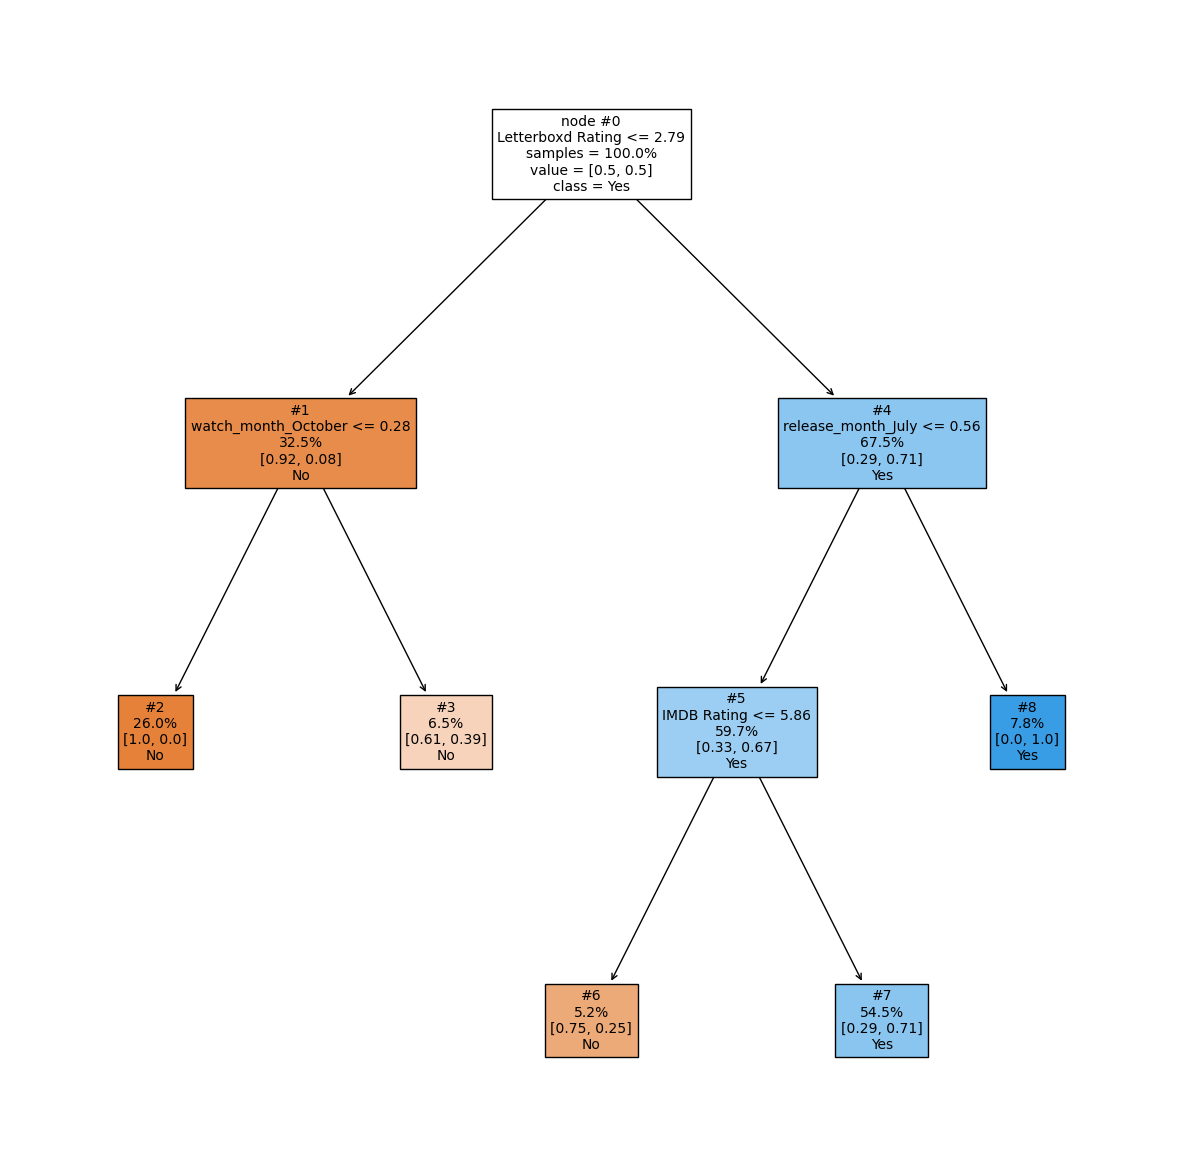

In [26]:
# Train and evaluate a Decision Tree classifier with specified parameters.
def run_model(d=3, cw='balanced', c='gini', s='random', msl=3):

    # Instantiate the Decision Tree classifier
    clf = tree.DecisionTreeClassifier(max_depth=d,
                                      class_weight=cw,
                                      criterion=c,
                                      splitter=s,
                                      min_samples_leaf=msl)

    # Train the classifier
    clf2 = clf.fit(x_train, y_train)

    # Plot the decision tree
    plt.figure(figsize=(15, 15))
    tree.plot_tree(clf2,
                   feature_names=feature_cols,
                   class_names=['No', 'Yes'],
                   filled=True, precision=2,
                   node_ids=True, fontsize=10,
                   label='root', proportion=True,
                   impurity=False)

    # Predict on the test set
    y_pred = clf2.predict(x_test)

    # Print classification report
    print(metrics.classification_report(y_test, y_pred))
    
    # Predict probabilities
    probabilities = clf2.predict_proba(x_test)[:, 1]

    return clf2, probabilities

# Train the model and get probabilities
trained_model, probabilities = run_model()

In [27]:
# Find the index of the movie with the highest predicted probability of being perfect
perfect_movie_index = np.argmax(probabilities)

# Extract details of the movie with the highest predicted probability
perfect_movie_details = movie2.iloc[perfect_movie_index]

# Drop the target columns from the perfect movie details
perfect_movie_details = perfect_movie_details.drop(['Target_No', 'Target_Yes'])

# Define a function to round float values to two decimal places
def round_float(x):
    if isinstance(x, float):
        return round(x, 2)
    else:
        return x

# Apply the rounding function to the perfect movie details
rounded_details = perfect_movie_details.apply(round_float)

# Print the rounded details of the perfect movie
print("The Perfect Movie Would Have These Stats:")
print(rounded_details)

The Perfect Movie Would Have These Stats:
Runtime                                                148
Real Budget                                 160000000.0000
Real Box Office                             839000000.0000
Real Profit                                 679000000.0000
Inflated Budget                             223429356.2900
Inflated Box Office                        1171607687.0300
Inflated Profit                             948178330.7500
ROI                                                 5.2400
RT Critics Rating                                  87.0000
RT Fan Rating                                      91.0000
MC Critics Score                                   74.0000
MC User Score                                       8.8000
IMDB Rating                                         8.8000
Letterboxd Rating                                   4.2000
Movie Age                                             4990
Movie Age At Watch                                    4986
Oscar Wins    